# **This notebook contains all the basic regression tools I use for my work.This will be modified with time and it's repo and previous copies are available in my github account.Theory behind all the cells will be included in a seprate notebook**

In [37]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(style="darkgrid")

In [38]:
#generate your dataset
def generate_data(location:str,sample_number=10):
  data=pd.read_csv(location)
  head=data.head()
  tail=data.tail()
  sample=data.sample(sample_number)
  description=data.describe()
  columns=data.columns
  info=data.info()
  shape=data.shape
  size=data.size
  return {'data':data,'head':head,'tail':tail,'sample':sample,'description':description,'columns':columns,'info':info,
          'shape':shape,'size':size}


In [39]:
data_set=generate_data('/content/Life Expectancy Data.csv')
data=data_set['data']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [40]:
def get_type(data):
  numeric=[]
  categorical=[]
  for col in data.columns:
    if data[f'{col}'].dtypes == 'object':
      categorical.append(col)
    else:
      numeric.append(col)
  return {'numeric':numeric,'categorical':categorical}

In [41]:
# check for null values and deal with them
# this function will take the type of process as well for both numeric and categorical data
def treat_null_values(data,numeric_type:str='mean'):
  types=get_type(data)
  numeric=types['numeric']
  categorical=types['categorical']
  if numeric_type == 'mean':
    for col in numeric:
      data[f'{col}']=data[f'{col}'].fillna(data[f'{col}'].mean())
  elif numeric_type == 'mode':
    for col in numeric:
      data[f'{col}']=data[f'{col}'].fillna(data[f'{col}'].mode())
  elif numeric_type == 'median':
    for col in numeric:
      data[f'{col}']=data[f'{col}'].fillna(data[f'{col}'].median())
  elif numeric_type == 'frequent':
    for col in numeric:
      data[f'{col}']=data[f'{col}'].fillna(data[f'{col}'].nunique[0])
  elif numeric_type == 'drop':
    for col in numeric:
      data[f'{col}']=data[f'{col}'].dropnna(inplace=True)
  elif numeric_type == 'predictive_modeling':
    pass # create a seprate function for this
  elif numeric_type == 'impute':
    pass # create a seprate function for this as well
  
  for col in categorical:
    most_frequent_category=data[f'{col}'].mode()[0]
    data[f'{col}'].fillna(most_frequent_category,inplace=True)
  return data

  

def predictive_modeling():
  pass #do a detailed study as disadvantages for this model usually outweights advantages
def multiple_imputation():
  from fancyimpute import IterativeImputer as MICE
  data= pd.DataFrame(MICE().fit_transform(data))
  return data

In [42]:
def encode_data(data,multiclass:str='One_hot',binary_class:str='Label'): #this function takes three args one is the data 2nd is the type of encoding for multiclass data and third is the encoding for binary class data
  categorical=get_type(data)['categorical']
  multivariate=[]
  bivariate=[]
  for col in categorical:
    if data[f'{col}'].nunique()>2:
      multivariate.append(col)
    else:
      bivariate.append(col)
  
  if multiclass == 'One_hot':
    for col in multivariate:
      data=encode_and_bind(data,col)
  if binary_class == 'Label':
    for col in bivariate:
      data=label_encode(data,col)
  # add other sorting techniques as well in here
  return data

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res.pop(feature_to_encode)
    return(res)

def label_encode(data,col):
  from sklearn.preprocessing import LabelEncoder
  encoder=LabelEncoder()
  data[col]=encoder.fit_transform(data[col])
  return data
  
# this function needs to be modified therefore add differenr sort of encoding techniques as well in this cll

In [43]:
def treat_outliers(data,feature:str,algo:str='IQR',z_threshold:int=3,add_feature=None,remove:bool=False,scatter:bool=False,feature_x=None,feature_y=None): # this function takes two arguments one is data and 2ns is the algorithm
  pass
  if scatter == True:
    px.scatter(data_px,x=feature_x,y=feature_y,hover_name='Country')
  else:
    if algo == 'IQR':
      outlier_index=Inter_quantile_range(data,feature)
    if algo == 'EEA': # elliptic envelope algo
      outlier_index=Elliptice_envelope_algo(data,feature,add_feature)
    if algo == 'ISF': # Isolate forest algo
      outlier_index=Isolate_forest_algo(data,feature)
    if algo == 'One_classSVM': # one class svm
      outlier_index=One_class_SVM(data,feature)
    if algo == 'LOF':
      outlier_index=Local_factor_outlier(data,feature)
    if algo == 'Z_score':
      outlier_index=Z_score_algo(data,feature,z_threshold)
    print(outlier_index)
    if remove == True:
      data=remove_outliers(outlier_index,data)
    
    return data
    


# in all these function display the index of outliers

def Local_factor_outlier(data,feature):
  import numpy as np 
  from sklearn.neighbors import LocalOutlierFactor
  X=data[[feature,data.columns.values[-1]]]
  lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                         metric='minkowski', contamination=0.04,
                         novelty=False, n_jobs=-1)
  pred = lof.fit_predict(X)
  outlier_index = np.where(pred==-1)
  return outlier_index

def One_class_SVM(data,feature): #this returns novelty I am guessing so fuck this method
  import numpy as np
  from sklearn.svm import OneClassSVM
  X=data[[feature,data.columns.values[-1]]]
  one_class_svm = OneClassSVM(kernel='rbf', degree=3, gamma='scale')
  new_data = np.array([[-4, 8.5]])# change these values as per your dataset
  one_class_svm.fit(X)
  pred = one_class_svm.predict(new_data)
  outlier_index = np.where(pred==-1)
  return outlier_index

def Isolate_forest_algo(data,feature):
  import numpy as np
  from sklearn.ensemble import IsolationForest
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler
  X=data[[feature,data.columns.values[-1]]]
   # Returns 1 of inliers, -1 for outliers
  iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=1.0, 
                          bootstrap=False, n_jobs=-1, random_state=1)
  pred = iforest.fit_predict(X)
 # Extract outliers
  outlier_index = np.where(pred==-1)
  return outlier_index

def Elliptice_envelope_algo(data,feature,add_feature):
  import numpy as np
  from sklearn.covariance import EllipticEnvelope
  elpenv = EllipticEnvelope(contamination=0.025, 
                          random_state=1)
  X=data[[feature,add_feature]]
# Returns 1 of inliers, -1 for outliers
  pred = elpenv.fit_predict(X)

# Extract outliers
  outlier_index = np.where(pred==-1)
  return outlier_index

def Inter_quantile_range(data,feature):
  Q1 = np.percentile(data[f'{feature}'], 25, interpolation = 'midpoint') 
  Q2 = np.percentile(data[f'{feature}'], 50, interpolation = 'midpoint') 
  Q3 = np.percentile(data[f'{feature}'], 75, interpolation = 'midpoint') 
  IQR = Q3 - Q1 
  low_lim = Q1 - 1.5 * IQR
  up_lim = Q3 + 1.5 * IQR
  outlier_index=[]
  for val in data[f'{feature}']:
    if val > up_lim or val <low_lim:
      outlier_index.append(data.index[data[f'{feature}'] == val].values[0])
  return outlier_index
         
def Z_score_algo(data,feature,z_threshold):
  mean = np.mean(data[f'{feature}'])
  std = np.std(data[f'{feature}'])
  print('mean of the dataset is', mean)
  print('std. deviation is', std)
  outlier_index = []
  for val in data[f'{feature}']:
    z = (val-mean)/std
    if z > z_threshold:
      outlier_index.append(data.index[data[f'{feature}'] == val].values[0])
  return outlier_index
  


# this function will remove the outliers if removal is allowed
def remove_outliers(index,data):
  for row in index:
    data.drop([row])
    print(f'dropped value at index {row}')
  return data

      

# if remove is true remove outliers else if it is false just return the index of outliers
# this will function will be returning two datasets the original one and one in which all the outliers are removed



In [ ]:
# balanced data only affects the classification model since regression datasets are continous therefore it doesn;t make
# much sense to balance data as there will be continuos values and therfore almost all the dependent values will be unique

In [44]:
# this function will perform all the data preprocessing steps
# incase you want to use non default algos call these function seprately
def preprocess_data(data):
  data=treat_null_values(data)
  data=encode_data(data)
  return data

# call outliers and balance function independentlu whenever you like and PS Fuck Roopa


In [45]:
data=preprocess_data(data)

In [ ]:
def create_heat_map(data):
  #correalation between varaibles
  plt.figure(figsize=(16, 6))
  heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
  heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
  # save heatmap as .png file
  # dpi - sets the resolution of the saved image in dots/inches
  # bbox_inches - when set to 'tight' - does not allow the labels to be cropped
  plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')# this will will also return two dataset one being the original one and second one will be the one in


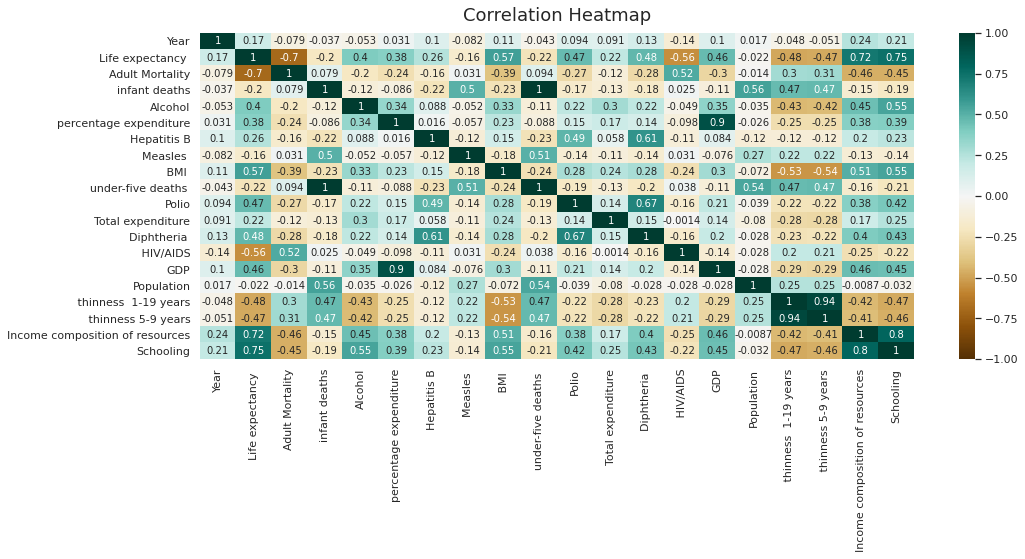

In [ ]:
raw_data=pd.read_csv('/content/Life Expectancy Data.csv')
create_heat_map(raw_data)

In [ ]:
# drawing plots will be much easier in direct manner therfore refer to original regression databook 
def SNS_distplot(feature:str,color:str='green'):
  sns.distplot(data[feature],color=color)
def SNS_histlpot(feature:str,shade:bool=True,color:str='blue'):
  sns.kdeplot(data[feature],shade=shade,color=color)
def SNS_kdeplot(feature:str,shade:bool=True,color:str='red'):
  sns.kdeplot(data[feature],shade=shade,color=color)
def SNS_jointplot(x:str,y:str,kind:str='kde',color:str='red'):
  sns.jointplot(data=data,x=x,y=y,color=color,kind=kind)
def SNS_scatterplot(x:str,y:str,color:str='blue'):
  sns.scatterplot(data=data,x=x,y=y,color=color)
def SNS_regPlot(x:str,y:str,color:str='magenta'):
  sns.regplot(x=data[x],y=data[y],color=color)
def PX_scatter(x:str,y:str,color:str,size:str,hover:str,facet_col:str,size_max:int=50):
  px.scatter(data,x=x,y=y,color=color,size=size,size_max=size_max,hover_name=hover,
           facet_col=facet_col)
def PX_scatterAnimate(x:str,y:str,animation_frame:str,animation_group:str,size:str,color:str,hover:str,range_x:list,range_y:list,log_x:bool=False,size_max:int=50):
  px.scatter(data, x=x, y=y, animation_frame=animation_frame, animation_group=animation_group,
           size=size, color=color, hover_name=hover,
           log_x=log_x, size_max=size_max, range_x=range_x, range_y=range_y)
    
def PX_chloropeth(location:str,color:str,hover:str,animation:str,projection:str):
  px.choropleth(data,locations=location,color=color,hover_name=hover,animation_frame=animation,
              color_continuous_scale=px.colors.sequential.Plasma,projection=projection)
'''
     These are all the projection options avaialble:
     'equirectangular', 'mercator', 'orthographic', 'natural earth', 'kavrayskiy7', 'miller',
      'robinson', 'eckert4', 'azimuthal equal area', 'azimuthal equidistant', 'conic equal area',
       'conic conformal', 'conic equidistant', 'gnomonic', 'stereographic', 'mollweide', 'hammer',
        'transverse mercator', 'albers usa', 'winkel tripel', 'aitoff', or 'sinusoidal'.
'''
  
def PX_histogram(x:str,y:str,color:str,hover:str):
  px.histogram(data,x=x,y=y,color=color,hover_name=hover)
def PX_box(x:str,y:str,category:str,categories:list,color:str,orientation:str='h',notched:bool=False):
  px.box(data,x=x,y=y,color=color,orientation=orientation,notched=notched,
       category_orders={category:categories})
def PX_violin(x:str,y:str,color:str,box:bool=False):
  px.violin(data,x=x,y=y,color=color,box=box,points='all')
def multiplot(features,type:str='dist',a:int=4,b:int=3):
  a = 4  # number of rows
  b = 3  # number of columns 
  c = 1  # initialize plot counter
  fig = plt.figure(figsize=(14,22))
  if type == 'dist':
    for feature in features:
      plt.subplot(a, b, c)
      plt.title(feature)
      ax1=sns.distplot(data[feature],hist=False,color="red",)
      c=c+1
      if c > a*b:
        break
  elif type == 'kde':
    for feature in features:
      plt.subplot(a, b, c)
      plt.title(feature)
      ax1=sns.kdeplot(data[feature],color="red",shade=True)
      c=c+1
      if c > a*b:
        break
  elif type == 'hist':
    for feature in features:
      plt.subplot(a, b, c)
      plt.title(feature)
      ax1=sns.histplot(data[feature],kde=True,color="red",)
      c=c+1
      if c > a*b:
        break
  elif type=='box':
    for feature in features:
      plt.subplot(a, b, c)
      plt.title(feature)
      ax1=sns.boxplot(data[feature],color="red",)
      c=c+1
      if c > a*b:
        break

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

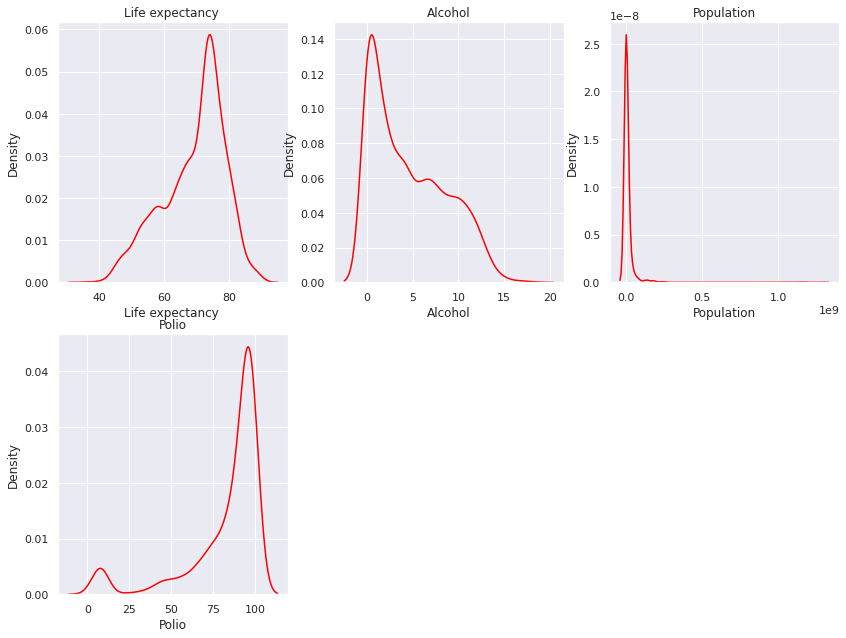

#Prepare a descriptive table in here on how to use this function

In [46]:
def split_data(data,dependent_feature:str,test_data_percentage=0.25,random_state=42):
  data=preprocess_data(data)
  last_column = data[dependent_feature]
  data.drop(dependent_feature, inplace=True, axis=1)
  data.insert(213,dependent_feature,last_column)
  x=data.iloc[:,:-1]
  y=data.iloc[:,-1]
  from sklearn.model_selection import train_test_split
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_data_percentage,random_state=random_state)
# this function takes three args one being the data and other the percent of test data and the random_state
# this function will return 4 args x_train,x_test,y_train,y_test
# add shape and size as well for all the params
# in this format 
  return{'x_train':{"data":x_train,"shape":x_train.shape,"size":x_train.size},
       'x_test':{"data":x_test,"shape":x_test.shape,"size":x_test.size},
       'y_train':{"data":y_train,"shape":y_train.shape,"size":y_train.size},
       'y_test':{"data":y_test,"shape":y_test.shape,"size":y_test.size}}

In [47]:
data_ready=split_data(data,'Life expectancy ')
x_test=data_ready['x_test']['data']
x_train=data_ready['x_train']['data']
y_test=data_ready['y_test']['data']
y_train=data_ready['y_train']['data']


In [48]:
def scale_data(x_train,x_test,type:str='Standard'):
  if type == 'Standard':
    from sklearn.preprocessing import StandardScaler
    sc=StandardScaler()
    x_train=sc.fit_transform(x_train)
    x_test=sc.transform(x_test)
  elif type == 'Normalize':
    pass
  
  return {'x_train':x_train,'x_test':x_test}
 # this function takes three args x_train,x_test and the type of scaling that should be applied



In [49]:
scaled_values=scale_data(x_train,x_test)
x_train=scaled_values['x_train']
x_test=scaled_values['x_test']


In [50]:
# seprate function for quantile,weighted and bootstrapping regression
def prepare_models(x_train,y_train,model:str='all'):
  models={}
  if model == 'all':
    Linear_regressor=Linear_regression(x_train,y_train)
    SVR_regressor=Support_vector_regression(x_train,y_train)
    Decision_tree_regressor=Decision_tree_regression(x_train,y_train)
    Random_forest_regressor=Random_forest_regression(x_train,y_train)
    XGB_regressor=XGB_regression(x_train,y_train)
    Ridge_regressor=Ridge_L2_regression(x_train,y_train)
    Kernel_ridge_regressor=Kernel_ridge_regression(x_train,y_train)
    Lasso_regressor=Lasso_L1_regression(x_train,y_train)
    Elastic_net_regressor=Elastic_net_regression(x_train,y_train)
    Hubber_regressor=Hubber_regression(x_train,y_train)
    Extra_tree_regressor=Extra_tree_regression(x_train,y_train)
    Bayseian_ridge_regressor=Bayseian_ridge_regression(x_train,y_train)
    Light_gradient_boosting_regressor=Light_gradient_boosting_regression(x_train,y_train)
    gradient_boosting_regressor=gradient_boosting_regression(x_train,y_train)
    adaboost_regressor=adaboost_regression(x_train,y_train)
    models={'LR':Linear_regressor,'SVR':SVR_regressor,'DT':Decision_tree_regressor,
            'RF':Random_forest_regressor,'XGB':XGB_regressor,'Ridge':Ridge_regressor,
            'Kernel_ridge':Kernel_ridge_regressor,'Lasso':Lasso_regressor,
            'Elastic':Elastic_net_regressor,'Hubber':Hubber_regressor,'ET':Extra_tree_regressor,
            'Bayseian':Bayseian_ridge_regressor,'Light':Light_gradient_boosting_regressor,
            'gradient':gradient_boosting_regressor,'adaboost':adaboost_regressor}
  elif model == 'LR':
    Linear_regressor=Linear_regression(x_train,y_train)
    models={'LR':Linear_regressor}
  elif model == 'SVR':
    SVR_regressor=Support_vector_regression(x_train,y_train)
    models={'SVR':Support_vector_regressor}
  elif model == 'DT':
    Decision_tree_regressor=Decision_tree_regression(x_train,y_train)
    models={'DT':Decision_tree_regressor}
  elif model == 'RF':
    Random_forest_regressor=Random_forest_regression(x_train,y_train)
    models = {'RF':Random_forest_regressor}
  elif model == 'XGB':
    XGB_regressor=XGB_regression(x_train,y_train)
    models={'XGB':XGB_regressor}
  elif model == 'Ridge':
    Ridge_regressor=Ridge_L2_regression(x_train,y_train)
    models={'Ridge':Ridge_regressor}
  elif model == 'Kernel_ridge':
    Kernel_ridge_regressor=Kernel_ridge_regression(x_train,y_train)
    models={'Kernel_ridge':Kernel_ridge_regressor}
  elif model == 'Lasso':
    Lasso_regressor=Lasso_L1_regression(x_train,y_train)
    models={'Lasso':Lasso_regressor}
  elif model == 'Elastic':
    Elastic_net_regressor=Elastic_net_regression(x_train,y_train)
    models={'Elastic':Elastic_net_regressor}
  elif model == 'Hubber':
    Hubber_regressor=Hubber_regression(x_train,y_train)
    models={'Hubber':Hubber_regressor}
  elif model == 'ET':
    Extra_tree_regressor=Extra_tree_regression(x_train,y_train)
    models={'ET':Extra_tree_regressor}
  elif model == 'Bayseian':
    Bayseian_ridge_regressor=Bayseian_ridge_regression(x_train,y_train)
    models={'Bayseian':Bayseian_ridge_regressor}
  elif model == 'Light':
    Light_gradient_boosting_regressor=Light_gradient_boosting_regression(x_train,y_train)
    models={'Light':Light_gradient_boosting_regressor}
  elif model == 'gradient':
    gradient_boosting_regressor=gradient_boosting_regression(x_train,y_train)
    models={'gradient':gradient_boosting_regressor}
  elif model == 'adaboost':
    adaboost_regressor=adaboost_regression(x_train,y_train)
    models={'adaboost':adaboost_regressor}

  return models




def Linear_regression(x_train,y_train):
  from sklearn.linear_model import LinearRegression
  regressor=LinearRegression()
  regressor.fit(x_train,y_train)
  return regressor

def Support_vector_regression(x_train,y_train):
  from sklearn.svm import SVR
  regressor=SVR(kernel='rbf')
  regressor.fit(x_train,y_train)
  return regressor

def Decision_tree_regression(x_train,y_train):
  from sklearn.tree import DecisionTreeRegressor
  regressor=DecisionTreeRegressor() 
  regressor.fit(x_train,y_train)
  return regressor

def Random_forest_regression(x_train,y_train):
  from sklearn.ensemble import RandomForestRegressor
  regressor=RandomForestRegressor(n_estimators=100)
  regressor.fit(x_train,y_train)
  return regressor

def XGB_regression(x_train,y_train):
  from xgboost import XGBRegressor
  regressor = XGBRegressor()#use this with jupyter notebool colab mei chod hai khuch gpu ki
  regressor.fit(x_train, y_train)
  return regressor

def Ridge_L2_regression(x_train,y_train):
  from sklearn.linear_model import Ridge
  regressor=Ridge(alpha=1.0)#alpha is the regularization parametre
  regressor.fit(x_train,y_train)
  return regressor

def Kernel_ridge_regression(x_train,y_train):
  from sklearn.kernel_ridge import KernelRidge
  regressor=KernelRidge(alpha=1.0)#alpha here is the regularization parameter
  regressor.fit(x_train,y_train)
  return regressor

def Lasso_L1_regression(x_train,y_train):
  from sklearn.linear_model import Lasso
  regressor=Lasso(alpha=0.1)#alpha here is the regularization parametre
  regressor.fit(x_train,y_train)
  return regressor

def Elastic_net_regression(x_train,y_train):
  from sklearn.linear_model import ElasticNet
  regressor=ElasticNet(random_state=42)
  regressor.fit(x_train,y_train)
  return regressor

def Hubber_regression(x_train,y_train):
  from sklearn.linear_model import HuberRegressor
  regressor=HuberRegressor(max_iter=100000)
  regressor.fit(x_train,y_train)
  return regressor

# def gamma_regressor(x_train,y_train):
#   pass
# def tweddie_regressor(x_train,y_train):
#   pass
def Extra_tree_regression(x_train,y_train):
  from sklearn.ensemble import ExtraTreesRegressor
  regressor=ExtraTreesRegressor(n_estimators=100,random_state=42)
  regressor.fit(x_train,y_train)
  return regressor
def Bayseian_ridge_regression(x_train,y_train):
  from sklearn.linear_model import BayesianRidge
  regressor=BayesianRidge()
  regressor.fit(x_train,y_train)
  return regressor

def Light_gradient_boosting_regression(x_train,y_train):
  from lightgbm import LGBMRegressor
  regressor=LGBMRegressor()
  regressor.fit(x_train,y_train)
  return regressor

def gradient_boosting_regression(x_train,y_train):
  from sklearn.ensemble import GradientBoostingRegressor
  regressor=GradientBoostingRegressor(random_state=42)
  regressor.fit(x_train,y_train)
  return regressor

def adaboost_regression(x_train,y_train):
  from sklearn.ensemble import AdaBoostRegressor
  regressor=AdaBoostRegressor(random_state=42)
  regressor.fit(x_train,y_train)
  return regressor


In [51]:
models=prepare_models(x_train,y_train)

[14:16:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
def make_predictions(models):
  predictions={}
  for model in models:
    y_pred=models[model].predict(x_test)
    predictions[f'y_pred_{model}']=y_pred
  return predictions
    
  

In [ ]:
predictions=make_predictions(models)

In [ ]:
def concatenate_test_pred(predictions,y_test):
  compare_predictions={}
  y_test=y_test.to_numpy()
  for prediction in predictions:
    y_pred=predictions[prediction]
    res=np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)
    compare_predictions[f'{prediction}_concatenated']=res
  return compare_predictions
  #this function will return  a dictionary containing the concatenated list of y_test and y_pred for each model

In [ ]:
compared_predictions=concatenate_test_pred(predictions,y_test)

In [ ]:
def visualize_models(y_test,predictions):
  a = 4  # number of rows
  b = 3  # number of columns 
  c = 1  # initialize plot counter
  fig = plt.figure(figsize=(14,22))
  for prediction in predictions:
    plt.subplot(a, b, c)
    plt.title(f'{prediction}')
    ax1=sns.distplot(y_test,hist=False,color="r",label="actual value")
    sns.distplot(predictions[prediction],hist=False,color="b",label="predicted values",ax=ax1)
    c=c+1
    if c > 12:
      break

def remaining_models(y_test,predictions):
  a = 4  # number of rows
  b = 3  # number of columns 
  c = 1  # initialize plot counter
  fig = plt.figure(figsize=(14,22))
  for prediction in ['y_pred_Bayseian','y_pred_Light','y_pred_gradient','y_pred_adaboost']:
    plt.subplot(a, b, c)
    plt.title(f'{prediction}')
    ax1=sns.distplot(y_test,hist=False,color="r",label="actual value")
    sns.distplot(predictions[prediction],hist=False,color="b",label="predicted values",ax=ax1)
    c=c+1
    if c > 12:
      break


#models here is a dict of models using which models will be evaluated

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

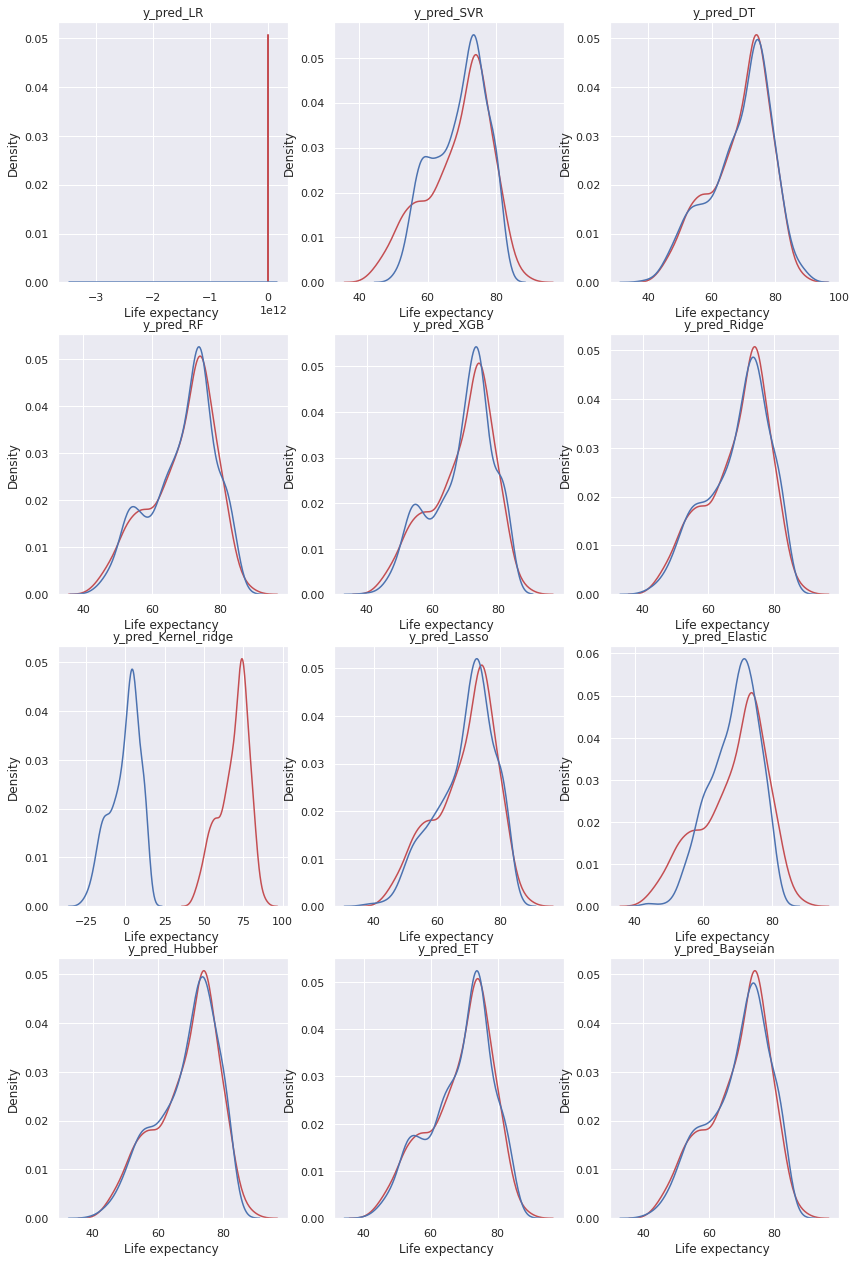

In [ ]:
visualize_models(y_test,predictions)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

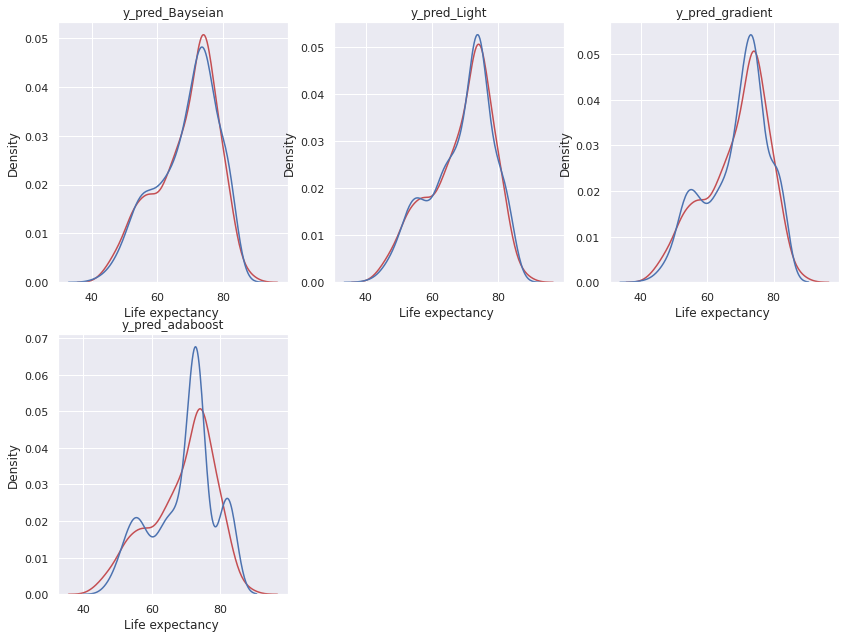

In [ ]:
remaining_models(y_test,predictions)


In [ ]:
def r2_score_models(models,x_train,y_train):
  from sklearn.model_selection import cross_val_score
  r2_score={}
  for model in models:
    accuracies = cross_val_score(estimator = models[model], X = x_train, y = y_train, cv = 10)
    mean_accuracy = accuracies.mean()
    r2_score[f'{model}_accuracy']={'accuracies':accuracies,'mean_accuracy':mean_accuracy}
  return r2_score


# in this function prepare a dictionary for all the models and the dict will include the mean r2 and the r2 score list

In [ ]:
r2_score=r2_score_models(models,x_train,y_train)



[14:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
#creting a dataframe
# for score in r2_score:
#   column=score
#   accuracies=r2_score[score]['accuracies']
#   mean_accuracy=r2_score[score]['mean_accuracy']
#   print(f'{column} \t Accuracies:{accuracies} \t mean_accuracy:{mean_accuracy} ')
index=[]
for i in range(0,len(r2_score)):
  index.append(i)
columns=['model_name','accuracies','mean_accuracy']
data=[]
for col in r2_score:
  model_name=col
  accuracies=r2_score[col]['accuracies']
  mean_accuracy=r2_score[col]['mean_accuracy']
  data.append([model_name,accuracies,mean_accuracy])

r2_data=pd.DataFrame(data=data,index=index,columns=columns)
r2_data=r2_data.sort_values(by=["mean_accuracy"],ascending=False) 
display(r2_data)


  


,model_name,accuracies,mean_accuracy
10,ET_accuracy,"[0.9718455555218382, 0.9707686158220425, 0.978...",9.674066e-01
3,RF_accuracy,"[0.9692357524474927, 0.9597410963782299, 0.969...",9.564668e-01
12,Light_accuracy,"[0.9608123499797984, 0.9633380193979382, 0.963...",9.552543e-01
5,Ridge_accuracy,"[0.9403333500061315, 0.9595710225115553, 0.961...",9.515613e-01
11,Bayseian_accuracy,"[0.939700366049812, 0.9590155438987494, 0.9607...",9.506042e-01
13,gradient_accuracy,"[0.948846478810758, 0.9451756588141735, 0.9535...",9.389192e-01
4,XGB_accuracy,"[0.9468908299295881, 0.9424975570307218, 0.950...",9.363198e-01
2,DT_accuracy,"[0.9438424054753797, 0.9036367717362882, 0.937...",9.152689e-01
7,Lasso_accuracy,"[0.9087048926139784, 0.9265737027330506, 0.921...",9.094690e-01
14,adaboost_accuracy,"[0.8934161245991369, 0.8887580636135267, 0.915...",8.895990e-01


In [ ]:
def model_evaluation(models,x_train,y_train):
  # metrics to be evaluated MAE	MSE	RMSE	Log error R2	RMSLE	MAPE
  test_model=models['ET']
  scoring=['neg_median_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error',
           'r2']
  
  index=[]
  for i in range(0,len(r2_score)):
    index.append(i)
  columns=['Model','MAE','MSE','RMSE','R2']
  
  from sklearn.model_selection import cross_val_score
  data_score=[]
  for model in models:
    data_premature=[]
    data_premature.append(model)
    for score in scoring:
      accuracies=cross_val_score(estimator=models[model], X = x_train, y = y_train, cv = 10,scoring=score,verbose=20,n_jobs=-1)
      data_premature.append(accuracies.mean())
    data_score.append(data_premature)
  score_data=pd.DataFrame(data=data_score,index=index,columns=columns)
  return score_data



    



In [ ]:
score_data=model_evaluation(models,x_train,y_train)
#word of advice modify models and include only those for which you want to know the matirces

In [ ]:
score_data=score_data.sort_values(by=["R2"],ascending=False) 
display(score_data)

,Model,MAE,MSE,RMSE,R2
10,ET,-0.392350,-2.898945e+00,-1.692861e+00,9.674066e-01
3,RF,-0.637150,-3.851068e+00,-1.966238e+00,9.569259e-01
12,Light,-0.805776,-3.968744e+00,-1.983467e+00,9.552543e-01
5,Ridge,-0.802079,-4.314414e+00,-2.071556e+00,9.515613e-01
11,Bayseian,-0.797392,-4.399593e+00,-2.092413e+00,9.506042e-01
13,gradient,-1.215864,-5.415948e+00,-2.324209e+00,9.389192e-01
4,XGB,-1.220155,-5.653331e+00,-2.374542e+00,9.363198e-01
2,DT,-0.710000,-7.614267e+00,-2.742094e+00,9.132993e-01
7,Lasso,-1.551059,-8.087916e+00,-2.839602e+00,9.094690e-01
14,adaboost,-2.003277,-9.830124e+00,-3.131126e+00,8.895990e-01


In [102]:
def hypertune_model(model_name:str):
  if model_name == 'DT':
    param_grid=DT_param_grid()
  elif model_name == 'RF':
    param_grid=RF_param_grid()
  elif model_name == 'SVR':
    param_grid=SVR_param_grid()
  elif model_name == 'XGB':
    param_grid=XGB_param_grid()
  elif model_name == 'Ridge':
    param_grid=Ridge_param_grid()
  elif model_name == 'Lasso':
    param_grid=Lasso_param_grid()
  elif model_name == 'Elastic':
    param_grid=Elastic_param_grid()
  elif model_name == 'Hubber':
    param_grid=Hubber_param_grid()
  elif model_name == 'ET':
    param_grid=ET_param_grid()
  elif model_name == 'Bayseian':
    param_grid=Bayseian_param_grid()
  elif model_name == 'Light':
    param_grid=Light_param_grid()
  elif model_name == 'gradient':
    param_grid=gradient_param_grid()
  elif model_name == 'adaboost':
    param_grid=adaboost_param_grid()
  from sklearn.model_selection import GridSearchCV
  grid=GridSearchCV(estimator=models[model_name],cv=10,verbose=20,n_jobs=-1,param_grid=param_grid,scoring='r2')
  grid.fit(x_train,y_train)
  # Checking the score for all parameters
  print("Grid scores on training set:")
  means = grid.cv_results_['mean_test_score']
  stds = grid.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

def DT_param_grid():
  max_depth=[]
  for i in range(0,400):
    max_depth.append(i)
    min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
    min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_features = list(range(1,x_train.shape[1]))
    criterion=['mse','mae','poison','friedman_mse']
  parameters={'criterion':criterion,'max_features':max_features,'min_samples_leaf':min_samples_leaf,'min_samples_split':min_samples_split}
  return parameters

def RF_param_grid():
  max_depth=[]
  for i in range(0,400):
    max_depth.append(i)
    min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
    min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_features = list(range(1,x_train.shape[1]))
    criterion=['mse','mae','poison','friedman_mse']
    n_estimators=np.linspace(1,100,100,endpoint=True)
    bootstrap=[True,False]
    oob_score=[True,False]
    warm_state=[True,False]
  parameters={'criterion':criterion,'max_features':max_features,'min_samples_leaf':min_samples_leaf,'min_samples_split':min_samples_split,
            'n_estimators':n_estimators,'bootstrap':bootstrap,'oob_score':oob_score,'warm_state':warm_state,'verbos':20}
  return parameters

def SVR_param_grid():
  parameters={'kernel':['rbf','poly','sigmoid'],
            'C': [1.1, 5.4, 170, 1001],
            'epsilon': [0.0003, 0.007, 0.0109, 0.019, 0.14, 0.05, 8, 0.2, 3, 2, 7],
            'gamma': [0.7001, 0.008, 0.001, 3.1, 1, 1.3, 5]}
  return parameters

def XGB_param_grid():
  
  params={'booster':['gblinear','gbtree','dart'],'gamma':[1e-2,1e-1,0.2,0.4,0.6,0.8,1.0,2.0,4.0,6.0,8.0,10.0,15.0,20.0],
           'importance_type':['gain','cover'],'leaning_rate':[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.9,1.0],
           'max_depth':[1,2,3,4,5,6,7,8,9,10],'min_child_weight':[1,2,4,5,3,6,7,8,9,10],'n_estimators':[100,200,300,400,500],
           'reg_alpha':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'reg_lambda':[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]}
  
  return params  

def Ridge_param_grid():
  parameters=[{'alpha':[1.0,10.0,100.0,1000.0],'solver':['auto','svd','chlosky','lsqr','sparse-cg','sag','saga'],'tol':[1e-4,1e-5,1e-3,1e-2,1e-1,0]}]
  return parameters

def Lasso_param_grid():
  parameters=[{'alpha':[1.0,10.0,100.0,1000.0],'positive':[False,True],'precompute':[True,False],'warm_start':[True,False],'tol':[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,0],'selection':['cyclic','random']}]
  return parameters

def Elastic_param_grid():
  parameters=[{'alpha':[1.0,10.0,100.0,1000.0],'positive':[False,True],'precompute':[True,False],'warm_start':[True,False],'tol':[1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,0],'selection':['cyclic','random'],'l1_ratio':[0.0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0]}]
  return parameters
  
def Hubber_param_grid():
  parameters={'alpha':[1e-4,1e-5,1e-3,1e-2,1e-1,0],'epsilon':[1.0,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50
                                                            ,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,1.95,2.0],
            'tol':[1e-05,1e-04,1e-03,1e-02,1e-01,0],
            'warm_start':[True,False]}
  return parameters

 # study these models first before creating the paramgird 
def ET_param_grid():
  max_depth=[]
  for i in range(0,400):
    max_depth.append(i)
    min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
    min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
    max_features = list(range(1,x_train.shape[1]))
    criterion=['mse','mae','poison','friedman_mse']
    n_estimators=np.linspace(1,100,100,endpoint=True)
    bootstrap=[True,False]
    oob_score=[True,False]
    warm_start=[True,False]
    parameters={'criterion':criterion,'max_features':max_features,'min_samples_leaf':min_samples_leaf,'min_samples_split':min_samples_split,
            'n_estimators':n_estimators,'bootstrap':bootstrap,'oob_score':oob_score,'warm_start':warm_start}
    return parameters
def Bayseian_param_grid():
  n_iter=[300,400,500]
  tol=[1e-3,1e-2,1e-1,1e-4]
  compute_score=[True,False]
  normalize=[True,False]
  verbose=20
  parameters={'n_iter':n_iter,'tol':tol,'compute_score':compute_score,'normalize':normalize}
  return parameters

def Light_param_grid():
  boosting_type=['gbdt','rf','dart','goss']
  learning_rate=[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.9,1.0]
  max_depth=[1,2,3,4,5,6,7,8,9,10]
  min_child_weight=[1,2,4,5,3,6,7,8,9,10]
  n_estimators=[100,200,300,400,500]
  reg_alpha=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
  reg_lambda=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]
  silent=[True,False]
  objective=['regression','regression_l1','regression_hubber','regression_fair','regression_poisson','resgression_mape','regression_gamma',
           'regression_tweedie','regression_mse','regression_rmse']
  parameters={'boosting_type':boosting_type,'learning_rate':learning_rate,'max_depth':max_depth,
            'min_child_weight':min_child_weight,'n_estimators':n_estimators,'reg-alpha':reg_alpha,
            'reg_lambda':reg_lambda,
            'silent':silent,'objective':objective}
  return parameters
def gradient_param_grid():
  learning_rate=[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.9,1.0]
  max_depth=[1,2,3,4,5,6,7,8,9,10]
  alpha=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
  n_estimators=[100,200,300,400,500]
  tol=[1e-3,1e-2,1e-1,1e-4]
  parameters={'learning_rate':learning_rate,'max_depth':max_depth,'alpha':alpha,'n_estimators':n_estimators,'tol':tol,
            'warm_start':[True,False]}
  return parameters
def adaboost_param_grid():
  n_estimators=[50,100,200,300,400,500]
  learning_rate=[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.9,1.0]
  loss=['linear', 'square', 'exponential']
  parameters={'n_estimators':n_estimators,'learning_rate':learning_rate,
            'loss':loss}
  return parameters




In [103]:
hypertune_model('Light')

KeyboardInterrupt: ignored

In [ ]:
def quantile_regression(quantile1:float=0.1,quantile2:float=0.5,quantile3:float=0.9,loss_plot:bool=False,prediction_plot:bool=True,hypertune:bool=False):
  from lightgbm import LGBMRegressor
  loss={}
  classifier={} #this is a dictionary in which we will install quantile value and coressponding preditred values
  for tau in [quantile1,quantile2,quantile3]:
    clf=LGBMRegressor(objective='quantile',alpha=tau)  # we are defining the objective as quantile since we want to minimize the quantile loss and alpha here is the quantile model we are predicting for
    clf.fit(x_train,y_train)
    preds=pd.DataFrame(clf.predict(x_test),columns=[str(tau)])
    y_pred=clf.predict(x_test)
    ghata=[]
    for actual,pred in zip(y_test,y_pred):
      ghata.append(actual-pred)
    loss[f'{tau} quantile']=ghata
    classifier[str(tau)]={'clf':clf,'predictions':preds}
  loss_df=pd.DataFrame()
  lossq1=[]
  lossq5=[]
  lossq9=[]
  actual_value=[]
  for val in loss['0.1 quantile']:
    lossq1.append(val.item())
  for val in loss['0.5 quantile']:
    lossq5.append(val.item())
  for val in loss['0.9 quantile']:
    lossq9.append(val.item())
  for val in y_test:
    actual_value.append(val)
  data_loss=[]
  for a,b,c,d in zip(lossq1,lossq5,lossq9,actual_value):
    data_loss.append([a,b,c,d])
  columns=[f'{quantile1} Loss',f'{quantile2} Loss',f'{quantile3} Loss','actual_value']
  index=[]
  for i in range (0,len(y_test)):
    index.append(i)
  loss_df=pd.DataFrame(data=data_loss,index=index,columns=columns)#this is the dataframe in which we store the quantile loss coressponding to each quantile value
  if loss_plot == True:
    plot_loss(loss_df,quantile1,quantile2,quantile3)
  
  #creating the model dataframe
  #creating a dataframe for the quantile and actual value
  values1=[]
  for val in classifier[f'{quantile1}']['predictions'].values:
    values1.append(val.item())
  values2=[]
  for val in classifier[f'{quantile2}']['predictions'].values:
    values2.append(val.item())
  values3=[]
  for val in classifier[f'{quantile3}']['predictions'].values:
    values3.append(val.item())
  values4=[]
  for val in y_test:
    values4.append(val)
  #creating data
  data_to_add=[]
  for a,b,c,d in zip(values1,values2,values3,values4):
    data_to_add.append([a,b,c,d])

  columns=[f'{quantile1} quantile',f'{quantile2} quantile',f'{quantile3} quantile','actual value']
  index=[]
  for i in range(0,len(y_test)):
    index.append(f'{i}')
  result=pd.DataFrame(data=data_to_add,index=index,columns=columns)
  get_insights(result,quantile1,quantile2,quantile3)
  if prediction_plot == True:
    plot_prediction(result,quantile1,quantile2,quantile3,values1,values2,values3)
  if hypertune == True:
    hypertune_model(clf)
  return result
  


def plot_loss(loss_df,quantile1,quantile2,quantile3):
   a = 4  # number of rows
   b = 3  # number of columns 
   c = 1  # initialize plot counter
   fig = plt.figure(figsize=(14,22))
   plt.subplot(a, b, c)
   plt.title(f'Plot for {quantile1} quantile')
   sns.kdeplot(x=loss_df[f'{quantile1} Loss'],y=loss_df['actual_value'],shade=True,color='green')
   c=c+1
   plt.subplot(a, b, c)
   plt.title(f'Plot for {quantile2} quantile')
   sns.kdeplot(x=loss_df[f'{quantile2} Loss'],y=loss_df['actual_value'],shade=True,color='blue')
   c=c+1
   plt.subplot(a, b, c)
   plt.title(f'Plot for {quantile3} quantile')
   sns.kdeplot(x=loss_df[f'{quantile3} Loss'],y=loss_df['actual_value'],shade=True,color='red')
def plot_prediction(result,quantile1,quantile2,quantile3,values1,values2,values3):
    a = 4  # number of rows
    b = 3  # number of columns 
    c = 1  # initialize plot counter
    fig = plt.figure(figsize=(14,22))
    plt.subplot(a, b, c)
    plt.title('Plot1')
    ax1=sns.kdeplot(y_test,color="orange",label="actual value",shade=True)
    sns.kdeplot(values1,color="red",label="q1",ax=ax1)
    sns.kdeplot(values2,color="green",label="q5",ax=ax1)
    sns.kdeplot(values3,color="blue",label="q9",ax=ax1)
    c=c+1
    plt.subplot(a, b, c)
    plt.title('Plot2')
    ax1=sns.kdeplot(y_test,color="green",label="actual value",shade=True)
    sns.kdeplot(values1,color="red",label="q1",ax=ax1)
    sns.kdeplot(values2,color="blue",label="q5",ax=ax1)
    c=c+1
    plt.subplot(a, b, c)
    plt.title('Plot3')
    ax1=sns.kdeplot(y_test,color="green",label="actual value",shade=True)
    sns.kdeplot(values1,color="red",label="q1",ax=ax1)
    sns.kdeplot(values2,color="blue",label="q9",ax=ax1)
    c=c+1
    plt.subplot(a, b, c)
    plt.title('Plot4')
    ax1=sns.kdeplot(y_test,color="green",label="actual value",shade=True)
    sns.kdeplot(values1,color="red",label="q5",ax=ax1)
    sns.kdeplot(values2,color="blue",label="q9",ax=ax1)
  
def get_insights(result,quantile1,quantile2,quantile3):
  print(f'Elements grater than {quantile1} quantile ')
  print((result['actual value']> result[f'{quantile1} quantile']).value_counts())
  print(f'Elements grater than {quantile2} quantile ')
  print((result['actual value']> result[f'{quantile2} quantile']).value_counts())
  print(f'Elements grater than {quantile3} quantile ')
  print((result['actual value']> result[f'{quantile3} quantile']).value_counts())


def hypertune_model(clf):
  from sklearn.model_selection import GridSearchCV
  parametres=[{'alpha':[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],'learning_rate':[1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5],'max_depth':[-1,1,2,3,4,5,6,7,8,9,10],'n_estimators':[100,200,300,400,500],'reg_alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'reg_lambda':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}]
  grid_search=GridSearchCV(estimator=clf,
                         param_grid=parametres,
                         scoring='r2',
                         cv=10,
                         n_jobs=-1,
                         verbose=10
                         )
  grid_search.fit(x_train,y_train)
  best_accruacy=grid_search.best_score_
  best_parametres=grid_search.best_params_
  print(f'best accuracy is {best_accuracy*100}')
  print(f'best parametres are {best_parametres}')


In [ ]:
def weighted_regression(approach:str='SKL'):
  if approach == 'SKL':
     scikitlearn()
  elif approach == 'STATS':
    stats_model()
def scikitlearn():
  from sklearn.utils.class_weight import compute_sample_weight
  sample_weights=compute_sample_weight(y=y_train,class_weight='balanced')
  display(sample_weights)
  # linear model using sampe weight as well
  from sklearn.linear_model import LinearRegression
  regressor=LinearRegression()
  regressor.fit(x_train,y_train,sample_weight=sample_weights)
  from sklearn.model_selection import cross_val_score
  accuracies_wls = cross_val_score(estimator = regressor, X = x_train, y = y_train, cv = 100)
  print('The r2 scores for the wls mode is :')
  print(accuracies_wls)
  print("The mean accuracy of wls model is :")
  print(accuracies_wls.mean())
def stats_model():
  import statsmodels.api as sm
  wls_model = sm.WLS(y,x)
  model=wls_model.fit()
  y_pred=model.predict(x_test)
  import seaborn as sns
  ax1=sns.distplot(y_test,hist=False,color="r",label="actual value")
  sns.distplot(y_pred,hist=False,color="b",label="predicted values",ax=ax1)
# wls model is not so good in our case hence proved WLS regression ki maa ka bhosda
  

In [ ]:
#all the steps of collinearity treatment will be done here and this is the last step of feature engineering as well in case you wana reduce the number of dependent features

def reduce_dimension(algo:str='PCA',kernel:str='rbf',reduced_dimension:int):
  if algo == 'PCA':
    reduced_data=Apply_PCA(reduced_dimension)
  elif algo == 'KPCA':
    reduced_data=Apply_KernelPCA(reduced_dimension,kernel)
  elif algo == 'LDA':
    reduced_data=Apply_LDA(reduced_dimension)
  return reduced_data

def Apply_PCA(reduced_dimension:int):
  from sklearn.decomposition import PCA
  pca=PCA(n_components=reduced_dimension)#n_component=reduced dimension of dataset
  x_train=pca.fit_transform(x_train)
  x_test=pca.transform(x_test)
  return {'x_train':x_train,'x_test':x_test}

def Apply_KernelPCA(reduced_dimension:int,kernel:str):
  from sklearn.decomposition import KernelPCA
  pca=KernelPCA(n_components=reduced_dimension,kernel=kernel)
  x_train=x_train.fit_transform(x_train)
  x_test=x_test.transform(x_test)
  return {'x_train':x_train,'x_test':x_test}

def Apply_LDA(reduced_dimension:int):
  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
  lda=LDA(n_components=reduced_dimension)#reduced dimension of dataset
  x_train=lda.fit_transform(x_train,y_train)#we need to pass dependent variable as well
  x_test=lda.transform(x_test)
  return {'x_train':x_train,'x_test':x_test}

In [ ]:
#bc ye bootstrapping susuri cheez kya hai?